# Выявление случаев нечестной сдачи экзамена

## Описание задания

remote testing system at the university - система удалённого тестирования в университете

В рамках задачи предложено поставить себя на место аналитика системы проведения экзаменов в университете.

Экзамены в системе проводятся в следующем формате. В обозначенное время экзаменуемые студенты приходят в специальный компьютерный класс в здании университета, каждый из них садится за свой компьютер, открывает систему и начинает решать задания в ней.

Для простоты будем считать, что задания в системе выдаются по очереди: после сдачи ответа по очередному заданию студенту выдаётся следующее без возможности вернуться к предыдущему. Для того чтобы завершить сдачу экзамена, необходимо ввести ответы на все вопросы. Также будем считать, что задания в системе бывают только тестового типа: в каждой задаче студенту нужно выбрать один из нескольких вариантов ответа.

Коллеги, которые проводят экзамены в системе, обратились с вопросом: были ли в рамках нескольких экзаменов случаи, когда ученики сдавали их нечестным путём? Проще говоря, были ли в рамках этих экзаменов случаи списывания?

Задача

Задача состоит в том, чтобы проанализировать данные о проведении экзаменов и проинформировать коллег о подозрительном поведении учеников, если оно имело место быть.

Важно: на основе анализа представленных данных мы можем только выдвинуть предположение о том, что кто-то из учеников списал экзамен. Доподлинно узнать ответ на этот вопрос мы не сможем, однако сможем обратить внимание коллег на подозрительное поведение учеников, похожее на списывание.

Таблица «exam»

В таблице содержится общая информация о проведённых экзаменах.

Таблица содержит следующие колонки:

«id» — уникальный идентификатор экзамена.

«start_date» — дата и время начала экзамена. Формат представления даты и времени: %Y-%m-%d %H:%M:%S.

«tasks_cnt» — число заданий в экзамене.

Таблица «user_answer»

В таблице содержится информация о том, какие ответы ученики давали на задания экзаменов. Каждая строчка соответствует ответу конкретного ученика на конкретное задание экзамена. Если ученик давал несколько ответов на задание экзамена, то в таблице будет сохранён только последний из них.

Таблица содержит следующие колонки:

«exam_id» — идентификатор экзамена, на задания которого ученик давал ответ.

«user_id» — идентификатор ученика в системе.

«task_ind» — номер задания, на которое ученик дал ответ.

«answer» — ответ, который дал ученик на данное задание. Ответ представляется в виде целого числа — номера ответа, который выбрал ученик.

«verdict» — вердикт экзаменационной системы по ответу ученика. Равен «OK» в случае, если ученик дал правильный ответ, и равен «WA» в противном случае.

«time» — момент времени, в который ученик дал ответ на задание. Формат момента времени: %Y-%m-%d %H-%M-%S.

## Постановка гипотез

Гипотеза 1. Есть студенты, которые списали у товарища

Метрики:
1. Доля совпавших ответов
2. Данные ответы даны в одинаковое время с точностью до нескольких секунд

Гипотеза 2. Есть студенты, которые списали с готовых ответов

Метрики:
1. Доля верных ответов
2. Данные ответы были даны слишком быстро

Проверка студентов, подозреваемых в списывании, остаётся за экзаменаторами по условию задачи

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Предобработка данных

In [3]:
exam = pd.read_csv('exam.csv')
user_answer = pd.read_csv('user_answer.csv')

In [4]:
exam.head()

,id,start_date,tasks_cnt
0,1,2023-12-15 10:00:00,16
1,2,2023-12-20 10:00:00,4


In [5]:
exam.dtypes

id             int64
start_date    object
tasks_cnt      int64
dtype: object

In [6]:
exam['start_date'] = pd.to_datetime(exam['start_date'], format = '%Y-%m-%d %H:%M:%S')

In [7]:
exam.dtypes

id                     int64
start_date    datetime64[ns]
tasks_cnt              int64
dtype: object

In [8]:
user_answer.head(3)

,exam_id,user_id,task_ind,answer,verdict,time
0,1,98,1,1,OK,2023-12-15 10-22-51
1,1,98,2,0,WA,2023-12-15 11-16-21
2,1,98,3,1,OK,2023-12-15 11-28-44


In [9]:
user_answer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4360 entries, 0 to 4359
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   exam_id   4360 non-null   int64 
 1   user_id   4360 non-null   int64 
 2   task_ind  4360 non-null   int64 
 3   answer    4360 non-null   int64 
 4   verdict   4360 non-null   object
 5   time      4360 non-null   object
dtypes: int64(4), object(2)
memory usage: 204.5+ KB


In [10]:
user_answer.dtypes

exam_id      int64
user_id      int64
task_ind     int64
answer       int64
verdict     object
time        object
dtype: object

In [11]:
user_answer['time'] = pd.to_datetime(user_answer['time'], format = '%Y-%m-%d %H-%M-%S')

In [12]:
user_answer.dtypes

exam_id              int64
user_id              int64
task_ind             int64
answer               int64
verdict             object
time        datetime64[ns]
dtype: object

Проверим временные выбросы

In [13]:
display(user_answer[user_answer['exam_id'] == 1].sort_values('time').head(3))
display(user_answer[user_answer['exam_id'] == 1].sort_values('time', ascending = False).head(3))

,exam_id,user_id,task_ind,answer,verdict,time
2208,1,102,1,2,WA,2023-12-15 10:00:08
576,1,90,1,1,OK,2023-12-15 10:00:10
2209,1,102,2,2,OK,2023-12-15 10:00:22


,exam_id,user_id,task_ind,answer,verdict,time
383,1,71,16,3,WA,2023-12-15 17:10:47
382,1,71,15,3,WA,2023-12-15 17:08:50
381,1,71,14,0,OK,2023-12-15 17:06:38


In [14]:
display(user_answer[user_answer['exam_id'] == 2].sort_values('time').head(3))
display(user_answer[user_answer['exam_id'] == 2].sort_values('time', ascending = False).head(3))

,exam_id,user_id,task_ind,answer,verdict,time
3840,2,328,1,3,WA,2023-12-20 10:00:01
2736,2,41,1,1,WA,2023-12-20 10:00:02
3056,2,17,1,2,OK,2023-12-20 10:00:03


,exam_id,user_id,task_ind,answer,verdict,time
4347,2,440,4,1,WA,2023-12-20 15:24:03
4346,2,440,3,2,WA,2023-12-20 15:22:18
4345,2,440,2,0,OK,2023-12-20 15:21:47


Добавим колонку, в которой указано время сдачи ответа от начала экзамена в минутах

In [15]:
user_answer_add = user_answer.copy()

In [16]:
mask = user_answer_add['exam_id'] == 1
user_answer_add.loc[mask, 'answer_time'] = user_answer_add.loc[mask, 'time'].apply(
    lambda x: (x.timestamp() - exam['start_date'][0].timestamp())//60
)

mask = user_answer_add['exam_id'] == 2
user_answer_add.loc[mask, 'answer_time'] = user_answer_add.loc[mask, 'time'].apply(
    lambda x: (x.timestamp() - exam['start_date'][1].timestamp())//60
)

In [17]:
user_answer_add.sample(5)

,exam_id,user_id,task_ind,answer,verdict,time,answer_time
242,1,26,3,0,WA,2023-12-15 10:17:37,17.0
1901,1,129,14,1,WA,2023-12-15 14:05:25,245.0
1263,1,83,16,3,WA,2023-12-15 11:59:29,119.0
4074,2,275,3,0,WA,2023-12-20 10:39:31,39.0
1375,1,51,16,3,WA,2023-12-15 13:58:12,238.0


In [18]:
user_answer_add_1 = user_answer_add[user_answer_add['exam_id'] == 1]
user_answer_add_2 = user_answer_add[user_answer_add['exam_id'] == 2]

<Axes: xlabel='answer_time', ylabel='Count'>

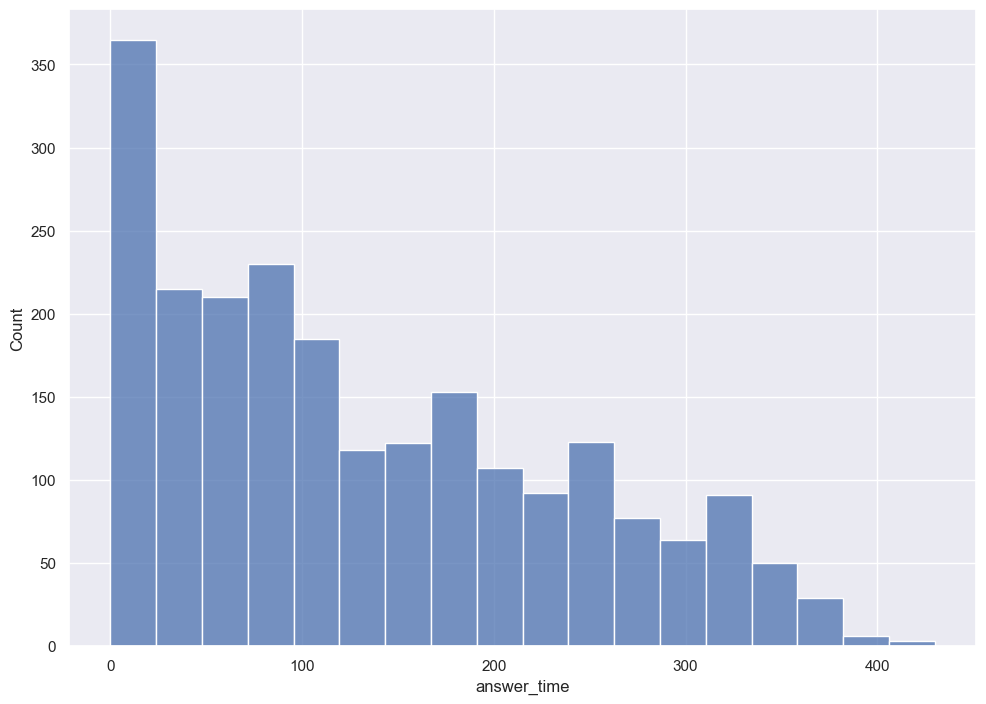

In [44]:
sns.histplot(user_answer_add_1['answer_time'])

<Axes: xlabel='answer_time', ylabel='Count'>

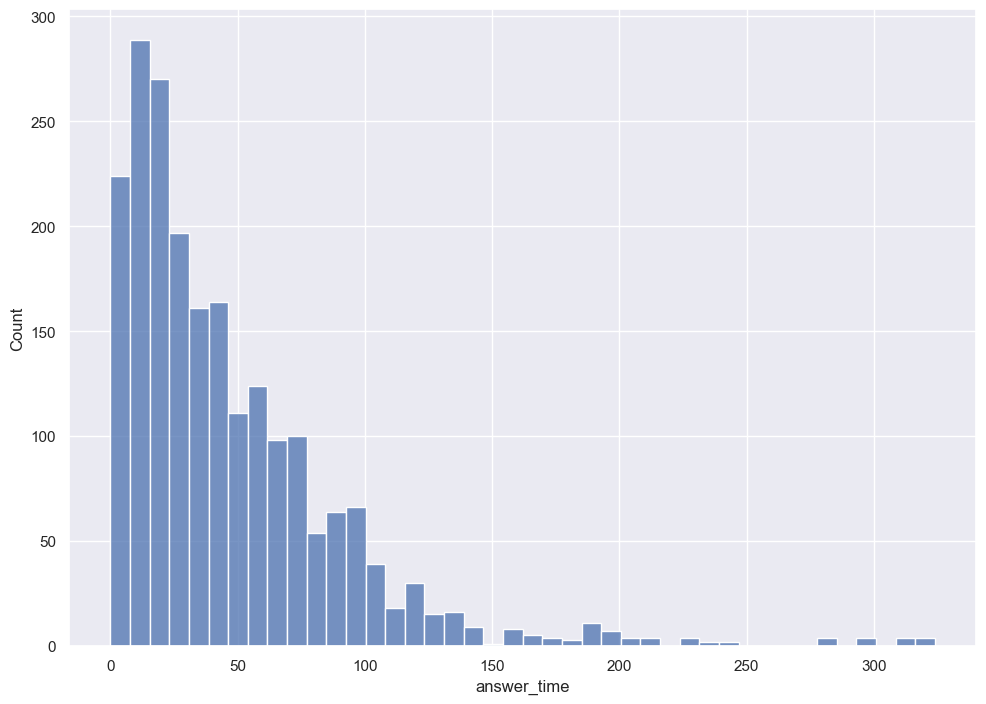

In [46]:
sns.histplot(user_answer_add_2['answer_time'])

Экзамены длились 7 и 5 часов соответственно, что вполне вероятно, хотя и редко

In [48]:
user_answer.nunique()

exam_id        2
user_id      530
task_ind      16
answer         4
verdict        2
time        3909
dtype: int64

<center>Выводы</center>


Видим всего 530 студентов, 16 вопросов в первом экзамене и 4 вопроса во втором экзамене, по 4 варианта ответов на вопрос. У каждого ответа зафиксировано время

1) Возникает идея отслеживать подозрительные пары студентов с большим количеством одинаковых ответов, которые были даны в приблизительно одинаковое время
2) Если ответы вводились слишком быстро, то есть подозрение, что студент вбивал готовые ответы

## Вычисление метрик для первой гипотезы

Для проверки первой гипотезы отберём студентов, у которых совпадает большая часть ответов и сами ответы даны близко друг к другу по времени

В ходе решения данной задачи оказалось, что приходится брать много данных из датафрейма, что замедляет выполнение кода. Для ускорения процесса отсеим нужные данные в словарь, с которым вычисления происходят значительно быстрее

In [15]:
def dftd(users_df):
    '''
    dataframe to dict
    Данная функция переводит нужные данные датафрейма в словарь
    users_df - датафрейм, из которого делаем проекция
    '''
    users_dict = {}

    for user_id in users_df['user_id'].unique():
        user_answers = users_df[users_df['user_id'] == user_id]['answer'].to_list()
        user_times = users_df[users_df['user_id'] == user_id]['time'].apply(lambda x: x.timestamp()).to_list()
        users_dict[user_id] = {
            'answers': user_answers,
            'times': user_times
        }

    return users_dict

In [16]:
def nma(s1_dict, s2_dict, t):
    '''
    number of matching answers - количество совпадающих ответов
    Данная функция подсчитывает количество совпадающих ответов двух студентов, причём рассматриваются ответы данные не далее t секунд друг от друга
    s1_dict - словарь с ответами и временем сдачи первого студента
    s2_dict - словарь с ответами и временем сдачи второго студента
    '''
    count = 0
    a1, a2 = s1_dict['answers'], s2_dict['answers']
    t1, t2 = s1_dict['times'], s2_dict['times']
    
    for i in range(len(a1)):
        if (a1[i] == a2[i]) and (abs(t1[i] -  t2[i]) <= t):
            count += 1
            
    return count

Сперва рассмотрим пары с первого экзамена

In [17]:
users_dict_1 = dftd(user_answer[user_answer['exam_id'] == 1])

Заметка для доработки. В предыдущем цикле использовался факт, что среди номеров i встретились все от 1 до 140. Подумать, как писать цикл, если какие-то номера пропущены

In [18]:
couples_1 = []
count_1 = []

for i in range(1, len(users_dict_1)):
    for j in range(i+1, len(users_dict_1) + 1):
        count = nma(users_dict_1[i], users_dict_1[j], 120)
        if count >= 8:
            couples_1 += [[i, j]]
            count_1 += [count]

В данном случае использование numpy не дало прироста в скорости

In [19]:
couples_1[:10]

[[1, 131],
 [8, 9],
 [8, 19],
 [8, 55],
 [9, 55],
 [27, 44],
 [60, 119],
 [77, 99],
 [105, 111]]

In [20]:
count_1[:10]

[12, 8, 9, 8, 8, 9, 8, 14, 11]

Если потребовать хотя бы 8 совпадений в ответах, то удаётся найти 9 подозрительных пар: [1, 131], [8, 9], [8, 19], [8, 55], [9, 55], [27, 44], [60, 119], [77, 99] и [105, 111]

Количество совпадений у данных пар 12, 8, 9, 8, 8, 9, 8, 14 и 11 соответственно

Теперь рассмотрим пары со второго экзамена

In [21]:
users_dict_2 = dftd(user_answer[user_answer['exam_id'] == 2])

In [22]:
couples_2 = []
count_2 = []

for i in range(1, len(users_dict_2)):
    for j in range(i+1, len(users_dict_2) + 1):
        count = nma(users_dict_2[i], users_dict_2[j], 120)
        if count >= 3:
            couples_2 += [[i, j]]
            count_2 += [count]

In [23]:
couples_2[:10]

[[3, 7],
 [3, 97],
 [3, 144],
 [4, 74],
 [7, 29],
 [7, 126],
 [7, 151],
 [9, 162],
 [10, 18],
 [10, 127]]

In [24]:
len(couples_2)

104

Слишком большое количество подозрительных пар. Значит требование в 3 совпадающих ответа из 4 недостаточное, у многие такое могло произойти и без списывания. Усилим условие до 4 совпавдения из 4

In [25]:
couples_2 = []
count_2 = []

for i in range(1, len(users_dict_2)):
    for j in range(i+1, len(users_dict_2) + 1):
        count = nma(users_dict_2[i], users_dict_2[j], 120)
        if count == 4:
            couples_2 += [[i, j]]
            count_2 += [count]

In [26]:
couples_2[:10]

[[10, 18],
 [10, 205],
 [18, 205],
 [33, 394],
 [70, 320],
 [93, 370],
 [112, 410],
 [132, 222],
 [181, 186],
 [199, 393]]

In [27]:
len(couples_2)

13

In [28]:
count_2[:10]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

In [29]:
couples_2

[[10, 18],
 [10, 205],
 [18, 205],
 [33, 394],
 [70, 320],
 [93, 370],
 [112, 410],
 [132, 222],
 [181, 186],
 [199, 393],
 [295, 470],
 [378, 530],
 [394, 527]]

13 подозрительных пар, у которых ответы идентичны и сделаны примерно в одно и тоже время выглядят более правдоподобным сценарием

Подозрительные пары: [10, 18], [10, 205], [18, 205], [33, 394], [70, 320], [93, 370], [112, 410], [132, 222], [181, 186], [199, 393], [295, 470], [378, 530] и [394, 527]

Среди данных пар не встретились подозрительные пары первого экзамена

## Вычисление метрик для второй гипотезы

Для проверки второй гипотезы отберём студентов, у которые между большей частью ответов затрачено значительно меньше времени, чем в среднем тратят все студенты

In [30]:
start_time = exam['start_date'][0].timestamp()

In [31]:
def ccqa(user_cor, user_times, t):
    '''
    count of correct quick answers - количество правильных быстрых ответов
    Данная функция вычисляет количество правильных ответов, которые были сделаны быстрее t секунд
    user_cor - список результатов ответов студента
    user_times - список времён сдачи ответов студента
    '''
    count = 0

    for i in range(len(user_cor)):
        if i == 0:
            if (user_cor[i] == 'OK') & ((user_times[i] - start_time) < t):
                count += 1
        elif (user_cor[i] == 'OK') & ((user_times[i] - user_times[i-1]) < t):
            count += 1

    return count

In [32]:
def dftd_1(users_df):
    '''
    dataframe to dict
    Данная функция переводит нужные данные датафрейма в массив
    users_df - датафрейм с данными
    '''
    users_dict = {}

    for user_id in users_df['user_id'].unique():
        verdicts = users_df[users_df['user_id'] == user_id]['verdict'].to_list()
        times = users_df[users_df['user_id'] == user_id]['time'].apply(lambda x: x.timestamp()).to_list()
        users_dict[user_id] = {
            'verdicts': verdicts,
            'times': times
        }

    return users_dict

Рассмотрим словарь студентов для первого экзамена

In [33]:
users_dict_1 = dftd_1(user_answer[user_answer['exam_id'] == 1])

Вычислим среднее время выполнения заданий студентами

In [34]:
avg_time_answers = []
total_students = len(users_dict_1)

for i in range(len(users_dict_1[1]['verdicts'])):
    sum = 0
    for j in range(1, total_students + 1):
        if i == 0:
            sum += users_dict_1[j]['times'][0] - start_time
        else:
            sum += users_dict_1[j]['times'][i] - users_dict_1[j]['times'][i-1]
    avg_time_answers += [sum / total_students]

In [35]:
avg_time_answers

[4479.9857142857145,
 509.57142857142856,
 523.9928571428571,
 455.07142857142856,
 447.09285714285716,
 476.72857142857146,
 472.29285714285714,
 477.40714285714284,
 503.2214285714286,
 468.5857142857143,
 459.25714285714287,
 411.3642857142857,
 397.25,
 530.6214285714286,
 527.0571428571428,
 465.79285714285714]

In [36]:
min(avg_time_answers[1:]), max(avg_time_answers[1:])

(397.25, 530.6214285714286)

Видим, что на ответы студенты в среднем тратят от 397 до 530 секунд, если не считать первый вопрос (в него входит время на подготовку к тесту)

Если студент правильно решает большую часть задач за значительно меньшее время, то будем считать такого студента подозрительным

In [81]:
susp_students = []
count_quick_answer = []

for i in range(1, len(users_dict_1) + 1):
    count = 0
    for j in range(len(users_dict_1[i]['verdicts'])):
        verdict = users_dict_1[i]['verdicts'][j]
        if (j == 0) & (verdict == 'OK') & ((users_dict_1[i]['times'][j] - exam['start_date'][0].timestamp()) <= 60):
            count += 1
        elif (verdict == 'OK') & ((users_dict_1[i]['times'][j] - users_dict_1[i]['times'][j-1]) <= 60):
            count += 1
    if count >= 8:
        susp_students += [i]
        count_quick_answer += [count]

In [82]:
susp_students

[11, 17, 29, 32, 41, 77, 89, 99, 102, 137]

In [83]:
count_quick_answer

[11, 15, 13, 12, 13, 15, 16, 13, 10, 13]

Найдено 10 учеников, которые на 8 и более вопросов потратили не более чем по 30 секунд и ответили верно

Будем считать учеников 11, 17, 29, 32, 41, 77, 89, 99, 102 и 137 подозрительными

Рассмотрим словарь студентов для второго экзамена

In [40]:
users_dict_2 = dftd_1(user_answer[user_answer['exam_id'] == 2])

In [41]:
avg_time_answers = []
total_students = len(users_dict_2)

for i in range(len(users_dict_2[1]['verdicts'])):
    sum = 0
    for j in range(1, total_students + 1):
        if i == 0:
            sum += users_dict_2[j]['times'][0] - exam['start_date'][1].timestamp()
        else:
            sum += users_dict_2[j]['times'][i] - users_dict_2[j]['times'][i-1]
    avg_time_answers += [sum / total_students]

In [42]:
avg_time_answers

[1957.3415094339623, 583.0415094339622, 629.1339622641509, 630.5301886792453]

Заметим, что в среднем на вопрос тратится по 583 - 630 секунд. Первый результат не в счёт, т.к. там могли быть организационные мероприятия, которые заняли время

In [84]:
susp_students = []
count_quick_answer = []

for i in range(1, len(users_dict_2) + 1):
    count = 0
    for j in range(len(users_dict_2[i]['verdicts'])):
        verdict = users_dict_2[i]['verdicts'][j]
        if (j == 0) & (verdict == 'OK') & ((users_dict_2[i]['times'][j] - exam['start_date'][1].timestamp()) <= 60):
            count += 1
        elif (verdict == 'OK') & ((users_dict_2[i]['times'][j] - users_dict_2[i]['times'][j-1]) <= 60):
            count += 1
    if count >= 3:
        susp_students += [i]
        count_quick_answer += [count]

In [85]:
susp_students

[74, 123, 135, 199, 319, 368, 393, 416]

In [86]:
count_quick_answer

[3, 3, 3, 3, 3, 3, 3, 3]

Найдено 8 учеников, которые на 3 вопроса потратили не более чем по 60 секунд и ответили верно

Будем считать учеников 74, 123, 135, 199, 319, 368, 393 и 416 подозрительными